# Neural Network Classification 

## 1. Introdução e Objetivo

Implementar manualmente um algoritmo de rede neural para classificar imagens da base de dados CIFAR 10 e comparar a acurácia dessa ferramenta com o algoritmo k-nearest neighbors (knn) que obteve 29% de acurácia.

## 2. Configuração e Carregamento de Dados

In [8]:
# Bibliotecas
import numpy as np
import random
import matplotlib.pylab as plt

# Funções de carregamento da base de dados CIFAR-10
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def ler_cifar(path, batch):
# ##################################    
# ler_cifar importa as imagens da base de dados CIFAR 10 
# Argumentos:
# path -- caminho que leva ao diretório da base de dados
# batch -- A base de dados contém 50 mil imagens divididas em 5 minibatches (lotes),
# este argumento é um escalar e define quantos minibatches serão importados. 
## Retorna: 
# X -- Uma matriz de tamanho (N, M) onde N é o número de imagens e M o tamanho da imagem vetorizada
# Y -- Um vetor 1D de tamanho (N, 1) que contém a classificação correta para cada imagem
# ##################################    

    X = np.empty((0,3072))
    Y = np.empty((1,0),dtype=int)
    if batch == 1:
        
        file = path + "\\data_batch_" + str(batch)
        
        dictionary = unpickle(file)
        X = dictionary[b'data']
        Y = np.asarray(dictionary[b'labels'])
            
    else:
            for i in range(1,batch+1):
                 file = path + "\\data_batch_" + str(i)        
                 dictionary = unpickle(file)
                 X = np.vstack([X,dictionary[b'data']])
                 temp = np.asarray(dictionary[b'labels'])
                 Y = np.append(Y,temp)
                
                 
    X = np.float32(X)   
    return X, Y

def cortar_dados(X,Y):

    training_indice = random.sample(range(len(X)),k=round(0.8*len(X)))
    training_indice = sorted(np.asarray(training_indice))
    
    test_indice = np.setdiff1d(range(len(X)), training_indice)
    
    
    Xapp = X[training_indice,:]
    Yapp = Y[training_indice]
    Yapp = np.reshape(Yapp, (len(Yapp), 1) )
    Xtest = X[test_indice,:]
    Ytest = Y[test_indice]
    
    return Xapp,Yapp,Xtest,Ytest    

def minibatch (X,Y,N):

    X = X[:N]    
    Y = Y[:N]
    
    return X,Y

def unflatten_image(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img   

In [9]:
# Carregamento de um minibatch e inspeção das dimensões dos dados
path = r"C:\Users\caiqu\Desktop\Data Science\AI Classification Problem\cifar-10-batches-py"  #
batch = 1
X, Y = ler_cifar(path, batch)
M = 500
X, Y = minibatch(X, Y, M)
Xapp, Yapp, Xtest, Ytest = cortar_dados(X, Y)
print('Train shape, Train labels, Test shape, Test labels:', Xapp.shape, Yapp.shape, Xtest.shape, Ytest.shape)

Train shape, Train labels, Test shape, Test labels: (400, 3072) (400, 1) (100, 3072) (100,)


C:\Users\caiqu\AppData\Local\Temp\ipykernel_21204\3133941632.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding='bytes')


## 3 Implementação da Rede Neural (Classe ANN)

Nesta seção, detalhamos a construção da classe ANN, que foi projetada para ser modular e eficiente na classificação do dataset CIFAR-10. Diferente de algoritmos como o K-Nearest Neighbors (KNN), que dependem da comparação direta entre instâncias de teste e treino, a rede neural busca aprender uma representação paramétrica (pesos e bias) que generalize as características das classes.
### 3.1. Arquitetura e Inicialização
A classe permite a definição de uma arquitetura personalizada através do parâmetro layers_size. 
- Inicialização de Kaiming (He): Para mitigar os problemas de gradientes desaparecendo ou explodindo, os pesos são inicializados seguindo a técnica de Kaiming: $W \sim N(0, \sqrt{2/n_{l}})$, onde $n_{l}$ é o número de neurônios da camada.
- Ajuste Dinâmico: A rede identifica e insere automaticamente a camada de entrada com base na dimensão dos dados fornecidos durante a execução do método fit.
### 3.2. Funções de Ativação
O script implementa funções essenciais para a introdução de não-linearidade no modelo:
- ReLU6: Uma variação da unidade linear retificada que limita a ativação no intervalo $[0, 6]$. Essa escolha é comum em arquiteturas que visam maior estabilidade numérica.
- Sigmoid: Disponível como alternativa para as camadas ocultas.
- Softmax: Aplicada na camada de saída, esta função transforma os valores finais em uma distribuição de probabilidade, onde a soma de todas as saídas é igual a 1.
### 3.3. Otimização e "Almost Adam"
A rede utiliza uma versão modificada do otimizador Adam (Adaptive Moment Estimation).
- Mecânica: O algoritmo mantém médias móveis do gradiente (first moment) e do quadrado do gradiente (second moment) para ajustar a taxa de aprendizado individualmente por parâmetro.
- Por que "Almost Adam"? A implementação é referida como "Almost" porque não inclui a etapa de correção de viés (bias correction) para as iterações iniciais, embora ainda capture os benefícios da inércia e do escalonamento adaptativo.
- Cosine Annealing: A taxa de aprendizado não é fixa; ela segue uma escala de cosseno que reduz o learning rate ao longo das iterações, permitindo que o modelo refine os pesos de forma mais suave conforme converge.
### 3.4. Regularização L2 e Função de Custo
Para evitar o overfitting — fenômeno onde o modelo decora o treino mas falha no teste — foi implementada a Regularização L2 (Weight Decay). A função de custo (Entropia Cruzada) é modificada para penalizar pesos excessivamente grandes:$$J = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)})] + \frac{\lambda}{2m} \sum_{l=1}^{L} \sum |W^{(l)}|^2$$Onde $\lambda$ (Lambda) controla a intensidade da regularização.

In [ ]:
class ANN:
    def __init__(self, layers_size,Lambda):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []
        self.accuracy = []
        self.accuracy_test = []
        self.Lambda = Lambda #Regularization Parameter
        self.beta1 = 0.9 #Adam almost parameter
        self.beta2 = 0.99 #Adam almost parameter
        
    def sigmoid(self, Z):
        Z = np.clip( Z, -500, 500 ) # Prevent overflow
        return 1 / (1 + np.exp(-Z))
 
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z)) # Shift the max value of Z to avoid the exponential to blow up
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def sigmoid_derivative(self, Z):
        Z = np.clip( Z, -500, 500 ) # Prevent overflow
        s = 1 / (1 + np.exp(-Z)) 
        return s * (1 - s)

    def relu(self,X):        
        return np.clip(X,0,6) # Relu6 implemented to avoid problems with +inf (ref Alex Krizhevsky article)
    
    def relu_derivative(self,X):
        X[X<=0] = 0
        X[X>0] = 1
        return X
 
    def initialize_parameters(self):
        np.random.seed(1)
        
        # Kaiming Weight Initialization
        
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / \
                np.sqrt(2 / self.layers_size[l])
                
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))
            
           # Initialization of paremeters used for Adams gradient descent 
            
            self.parameters["firstW" + str(l)] = 0
            self.parameters["secondW" + str(l)] = 0            
            self.parameters["firstb" + str(l)] = 0
            self.parameters["secondb" + str(l)] = 0
              
 
    def forward(self, X, activ_function):
        
# #######################################
#  Implement the foward propagation.
        # Argument:
#     X -- input data of shape (number of examples,size of one example)
#     activ_function -- activation function of the hidden layers

#     Returns:
#     A -- The results of the output layer
#     store -- a dictionary containing "W1", "W2", "Z1", "Z2", "A1" and "A2" and so on
        
        store = {}
        
        A = X.T
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            A = activ_function(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.softmax(Z) # Output layer function
        
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z
 
        return A, store
    
    def adam(self,first,second,dx):
# #######################################
# Implement the Almost Adam optimization. Updates the first and second moment.
# Argument:
# first - first moment from step_(n-1)
# second - second moment from step_(n-1)
# Return:
# first - first moment from step_n
# second - second moment from step_n
                 
            first = self.beta1 * first + (1-self.beta1) * dx
            second = self.beta2 * second + (1-self.beta2) * dx * dx               
            
            return first,second

    
    def backward(self, X, Y, store,activ_deriv):

# #######################################
#  Implement the backward propagation.

#  Arguments:
# activ_deriv -- derivative of the activation function chosen for the hidden layers 
# store -- a dictionary containing "Z1", "A1", "Z2" and "A2". Cache output from forward_propagation()
# X -- input data of shape (number of examples,size of one example)
# Y -- "true" labels vector of shape (number of examples,number of different classes)

# Returns:
# derivatives -- python dictionary containing your gradients with respect to different parameters
# ##################################
        
        derivatives = {}
        
        store["A0"] = X.T
 
        A = store["A" + str(self.L)]
        
        
        dZ = A - Y.T  # Cross entropy derivative
       
        
        # dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n + (self.Lambda/X.shape[0])*store["W" +str(self.L)]
        
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        dAPrev = store["W" + str(self.L)].T.dot(dZ)
 
        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db
 
        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * activ_deriv(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T) + (self.Lambda/X.shape[0])*store["W" +str(l)]
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)
 
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
 
        return derivatives
 
    def fit(self, X, Y,activ_function,learning_rate = 1  , n_iterations=1000):
# #######################################
# fit function - fits the NN to the data training         
# Argument: 
# X -- can be either only the X_test or a list containing X_train and X_test in this order.
# Y -- can be either only the Y_test or a list containing Y_train and Y_test in this order.      
# #######################################        
        
        
        
        if activ_function == 'relu':
            function = self.relu
            deriv = self.relu_derivative
        elif activ_function == 'sigmoid':
            function = self.sigmoid
            deriv = self.sigmoid_derivative
        else:
            print('Function not supported')
            exit()
        
        if len(X) == 2: #Assumes that both train and test batches were given at once
        # Else do nothing - only the train batch was given
            train_x,test_x = X
            train_y,test_y = Y
            X = train_x
            Y = train_y
            
        
        learning_init = learning_rate
        np.random.seed(1)
        
        self.n = X.shape[0]
        self.layers_size.insert(0, X.shape[1])
         
        #
        D = 10 #Number of learning rate restarts during training. Does not work with 0
        self.cycle = np.array(range(round(n_iterations/D)))
       
 
        self.initialize_parameters()
        
        
        for loop in range(n_iterations):
            
            learning_rate = 0.5 * learning_init * (1 + np.cos(np.roll(self.cycle,-loop)[0] * np.pi / D)) 
            A, store = self.forward(X,function)
            
            L2_regularization = 0
            
            for l in range(1, self.L + 1):
                
                
                L2_regularization = L2_regularization + np.sum(np.square(self.parameters["W" + str(l)]))
                
                
            
            L2_regularization = L2_regularization*self.Lambda*0.5/Y.shape[0]
            
            cost = -np.mean(Y * np.log(A.T+ 1e-8)) + L2_regularization
            derivatives = self.backward(X, Y, store,deriv)
            
            
                
            for l in range(1, self.L + 1):  
                
                
                # Adam almost 
                # The lines below are difficult to read so here I write a concise example
                # where the subscripts indicate the step count  
                #  firstW1_(i+1),secondW1_(i+1) = adam(firstW1_i,secondW1_i,dW)
                
                self.parameters["firstW" + str(l)],self.parameters["secondW" + str(l)] = \
                self.adam(self.parameters["firstW" + str(l)],self.parameters["secondW" + str(l)],derivatives["dW" + str(l)])
                
                self.parameters["W" + str(l)] -= learning_rate * self.parameters["firstW" + str(l)] / \
                np.sqrt(self.parameters["secondW" +str(l)] + 1e-7) 
                                
                self.parameters["firstb" + str(l)],self.parameters["secondb" + str(l)] = \
                self.adam(self.parameters["firstb" + str(l)],self.parameters["secondb" + str(l)],derivatives["db" + str(l)])
                
                self.parameters["b" + str(l)] -= learning_rate * self.parameters["firstb" + str(l)] / \
                np.sqrt(self.parameters["secondb" +str(l)] + 1e-7) 
 
            if loop % 100 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y,function))
                # Restart for Learning rate
                
                
            if loop % 10 == 0:
                self.costs.append(cost)
                self.accuracy.append(self.predict(X, Y,function))
                self.accuracy_test.append(self.predict(test_x, test_y,function))
                
    def predict(self, X, Y,function):
        
        A, cache = self.forward(X,function)
        
        # These two lines bellow do the oposite of the hot_encoder function
        # transforms the output data with size (N,C) to (N,1) to evaluate the accuracy
        
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.title("Neural Network - " + str(sum(layers_dims[1:-1])) + " Neurons - " + str(len(layers_dims)-1) + " Layers" )
        plt.legend('Train dataset')
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()        


    def  plot_acc(self):        
        plt.figure()
        plt.plot(np.arange(len(self.accuracy)), self.accuracy)
        plt.title("Neural Network - " + str(sum(layers_dims[1:-1])) + " Neurons - " + str(len(layers_dims)-1) + " Layers" )
        plt.legend('Train dataset')
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.show()     
        
    def plot(self):
        
        plt.figure()
        
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.title("Neural Network - " + str(sum(layers_dims[1:-1])) + " Neurons - " + str(len(layers_dims)-1) + " Layers" )
        plt.ylabel("cost")
        
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(len(self.accuracy_test)), self.accuracy_test)
        plt.legend('Test dataset')
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.show() 

# Criando um modelo de rede neural artificial com 2 camadas ocultas e coeficiente de regularização L2 (lambda) igual a 0.3
layers_dims = [100,10] # 2-layer model
ann = ANN(layers_dims,Lambda = 0.3)

## Data Pipeline (CIFAR-10)

O script inclui funções auxiliares para lidar com o formato específico do conjunto de dados CIFAR-10:
- One-Hot Encoding: A função hot_encoder converte rótulos de classe (como 3) em vetores (como $[0,0,0,1,0,0,0,0,0,0]$), o que é necessário para calcular a perda de Entropia Cruzada (Cross-Entropy loss).
- Normalização: Em pre_process_data, os valores dos pixels (0–255) são divididos por 255 para escaloná-los entre 0 e 1. A função também realiza a subtração da média, o que centraliza os dados em torno de zero, ajudando a rede neural a convergir mais rapidamente.

In [11]:
def hot_encoder(Y):
 # Changes the input Y with size (N,1) to a 2D matrix with size (N,C)
 # where N is the number of data and C the number of different classes
 # C = 10.  
    C = 10 ;  
    out = np.zeros((len(Y),C))
    
    for i in range(len(Y)):
           
        out[i,Y[i]] = 1
        
    return out
 
def pre_process_data(train_x, train_y, test_x, test_y):
    # Normalize
    train_x = train_x / 255.
    test_x = test_x / 255.
    
    # Subtract the mean image from data.
    train_x -= np.mean(train_x,axis=0)
    test_x -= np.mean(test_x,axis=0)
    
    # Transform Data from size (N,1) to (N,C) where N is the number of data 
    # and C the number of different classes
    train_y = hot_encoder(train_y)
    test_y = hot_encoder(test_y)
 
    return train_x, train_y, test_x, test_y

# Pre-processamento dos dados para remover a média e normalizar

train_x, train_y, test_x, test_y = pre_process_data(Xapp, Yapp, Xtest, Ytest)

train_x =  train_x.astype(np.float64)
test_x =  test_x.astype(np.float64)

# definir base de dados de treino e teste

X = [train_x,test_x]
Y = [train_y,test_y]

## Treinando a rede neural

Cost:  5755.103881462 Train Accuracy: 14.249999999999998
Cost:  3568.98253745586 Train Accuracy: 79.75
Cost:  1940.6631992062523 Train Accuracy: 85.5
Cost:  902.3728535577895 Train Accuracy: 97.25
Cost:  350.80026878767865 Train Accuracy: 97.5
Cost:  133.02145558992277 Train Accuracy: 85.0
Cost:  93.0588855929094 Train Accuracy: 86.25
Cost:  66.89138607777876 Train Accuracy: 91.5
Cost:  28.13303053095963 Train Accuracy: 95.25
Cost:  12.979622558333338 Train Accuracy: 96.75
Cost:  13.717606744274427 Train Accuracy: 98.0
Cost:  6.673226888435168 Train Accuracy: 95.0
Cost:  7.547602922152307 Train Accuracy: 80.75
Cost:  2.230789375474896 Train Accuracy: 100.0
Cost:  0.15462271847396275 Train Accuracy: 100.0
Cost:  0.11118266566124364 Train Accuracy: 100.0
Cost:  23.122399182061198 Train Accuracy: 64.0
Cost:  13.86833502970221 Train Accuracy: 96.0
Cost:  0.7978389924994082 Train Accuracy: 100.0
Cost:  0.13892401204045918 Train Accuracy: 100.0
Cost:  0.11257003131639294 Train Accuracy: 100.

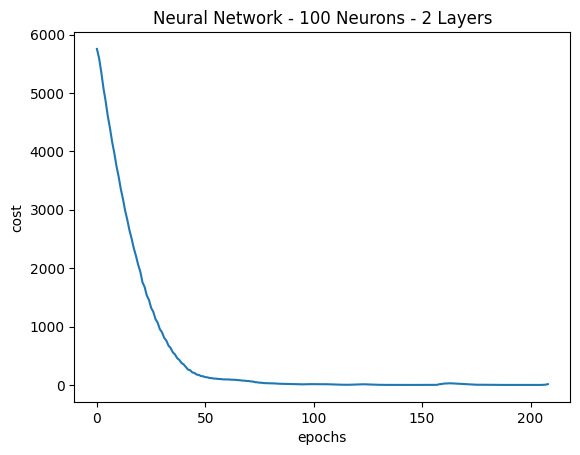

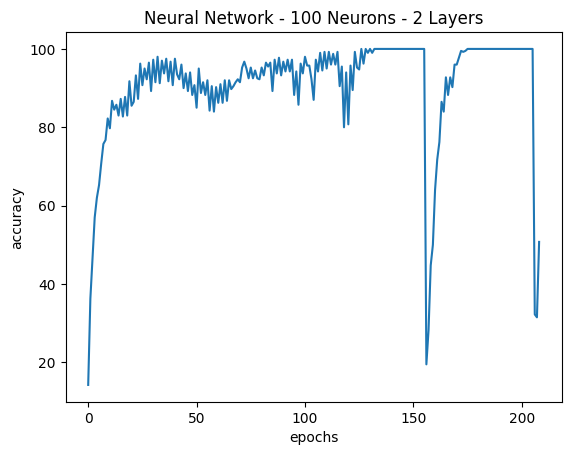

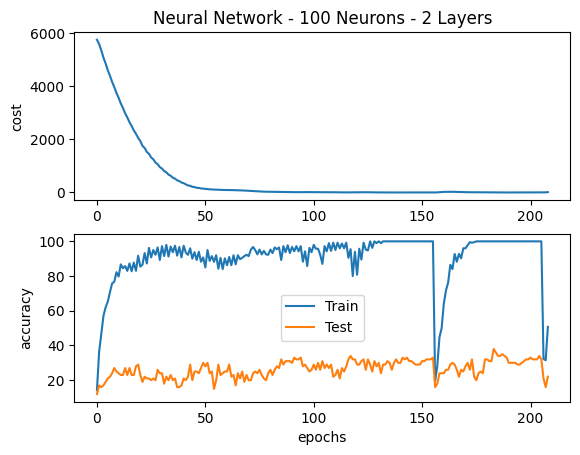

In [12]:
# Treinamento da rede neural artificial com relu como função de ativação 
# learning_rate e n_iterations podem ser ajustados conforme necessário

ann.fit(X, Y, 'relu',learning_rate=0.1, n_iterations = 2085 )

print("Train Accuracy:", ann.predict(train_x, train_y, ann.relu))
print("Test Accuracy:", ann.predict(test_x, test_y, ann.relu))


# Plotando custo e acurácia

ann.plot_cost()
ann.plot_acc()
ann.plot()